In [1]:
import pygmt
import gsw
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

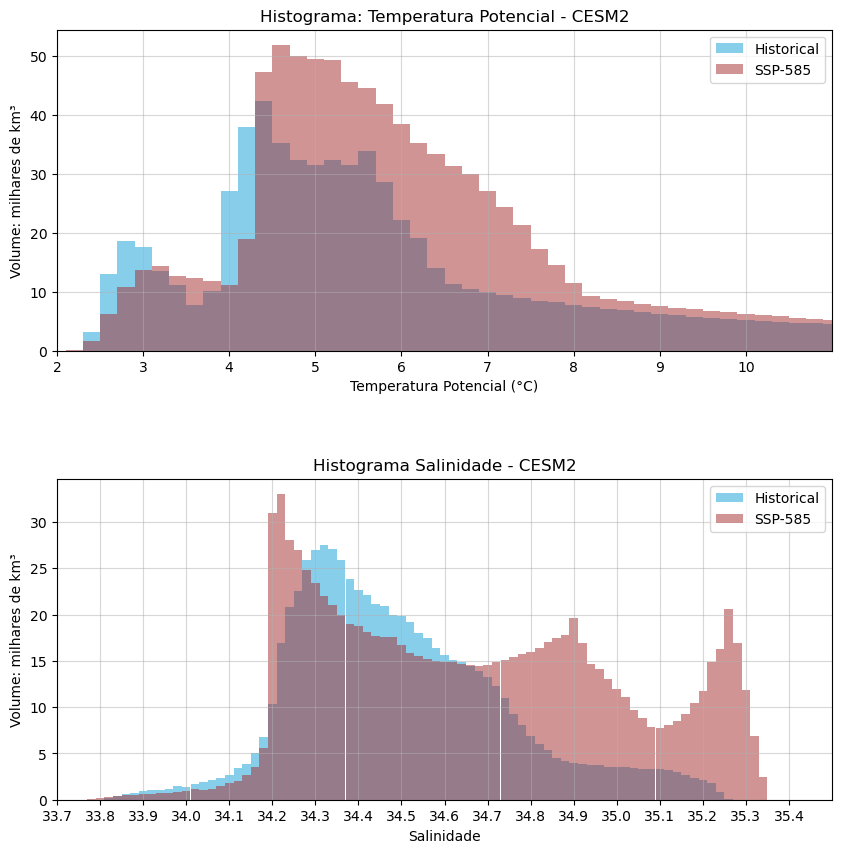

In [3]:
#Df com intervalo de 0.2 para temperatura e 0.02 para salinidade
#Profundidade de acordo com o caminho da pasta

#Grid 1
df = pd.read_parquet("Dataframes_50S_20S/CMIP.NCAR.CESM2.historical.parquet")

#Divide o volume
df.vol = df.vol/1e13

#Retira esses valores mínimos que defini, para não atrapalhar na criação correta da superfície pelo pygmt. Esses valores são devido a criação de um ponto médio para os intervalos, porem como eram pontos minimos e o intervalo a esqueda não está inserido, o pandas cria tipo o intervalo de (-2, -1.98], será (-2.00001, -1.98] fazendo com que a média seja -1.9005, oque pode atrapalhar na criação correta do grid pelo pygmt
df = df.loc[(df.thetao > -1.9005) & (df.so > 33.0095)]

#Seleciona a região, importante que seja os mesmos valores minimos e maximos do meu dataframe.
region = [-1.7, 19.9, 33.03, 36.99]

grid = pygmt.surface(
    x=df.thetao,
    y=df.so,
    z=df.vol,
    spacing="0.2/0.02",
    region=region,  # xmin, xmax, ymin, ymax
    tension=0.50,
    lower=0,
)

#Grid 2
df = pd.read_parquet("Dataframes_50S_20S/ScenarioMIP.NCAR.CESM2.ssp585.parquet")

df.vol = df.vol/1e13

df = df.loc[(df.thetao > -1.9005) & (df.so > 33.0095)]

grid2 = pygmt.surface(
    x=df.thetao,
    y=df.so,
    z=df.vol,
    spacing="0.2/0.02",
    region=region,  # xmin, xmax, ymin, ymax
    tension=0.50,
    lower=0,
)

diff = (grid2 - grid)

diff_pos = xr.where(diff>0, diff, 0)

grid = grid.rename({"y":"so", "x" : "thetao"})
grid2 = grid2.rename({"y":"so", "x" : "thetao"})

temp_1 = grid.sum(dim="so")
temp_2 = grid2.sum(dim="so")
y1_T = temp_1.values
x1_T = temp_1.thetao.values

y2_T = temp_2.values
x2_T = temp_2.thetao.values

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 10))

# Plotar o primeiro histograma no primeiro eixo
ax1.hist(x1_T, bins=x1_T, weights=y1_T, label='Histograma 1', color="skyblue")

# Plotar o segundo histograma no primeiro eixo
ax1.hist(x2_T, bins=x2_T, weights=y2_T, alpha=0.5, label='Histograma 2', color="brown")

# Configurar rótulos e título
ax1.set_xlabel('Temperatura Potencial (°C)')
ax1.set_ylabel('Volume: milhares de km³')
ax1.set_title('Histograma: Temperatura Potencial - CESM2')
ax1.set_xlim(2, 11)
ax1.set_xticks(list(range(2, 11, 1)))
ax1.grid(alpha=0.5)
# Mostrar a legenda
ax1.legend(["Historical", "SSP-585"])

so_1 = grid.sum(dim="thetao")
so_2 = grid2.sum(dim="thetao")
y1_S = so_1.values
x1_S = so_1.so.values

y2_S = so_2.values
x2_S = so_2.so.values

# Plotar o primeiro histograma no primeiro eixo
ax2.hist(x1_S, bins=x1_S, weights=y1_S, label='Histograma 1',  color="skyblue")

# Plotar o segundo histograma no primeiro eixo
ax2.hist(x2_S, bins=x2_S, weights=y2_S, alpha=0.5, label='Histograma 2', color="brown")

# Configurar rótulos e título
ax2.set_xlabel('Salinidade')
ax2.set_ylabel('Volume: milhares de km³')
ax2.set_title('Histograma Salinidade - CESM2')
ax2.set_xlim(33.7, 35.5)
ax2.set_xticks(np.arange(33.7, 35.5, 0.1))
ax2.grid(alpha=0.5)

# Mostrar a legenda
ax2.legend(["Historical", "SSP-585"])

#Controlar espaçamento vertical entre os subplots
plt.subplots_adjust(hspace=0.4)

plt.savefig("Histogramas.png")

# Mostrar o gráfico
plt.show()

### Interpola os dados em x e y para criar mais pontos de grid e melhorar a visualização no plot 3D. Principalmente no matplotlib e plotly

In [40]:
diff = grid2-grid

In [41]:
grid = grid.sel(thetao=slice(0, 12), so=slice(33.8, 35.5))
grid2 = grid2.sel(thetao=slice(0, 12), so=slice(33.8, 35.5))

In [42]:
grid = pygmt.grdsample(grid=grid, spacing=[0.02, 0.002], interpolation="b")
grid2 =  pygmt.grdsample(grid=grid2, spacing=[0.02, 0.002], interpolation="b")

In [43]:
tempL = np.linspace(0, 12)
salL = np.linspace(34, 35.5)

Tg, Sg = np.meshgrid(tempL, salL)
sigma_theta = gsw.sigma0(Sg, Tg)

dens = xr.Dataset({
    'sigma_theta': (['salinity', 'temperature'], sigma_theta),
}, coords={'salinity': salL, 'temperature': tempL})


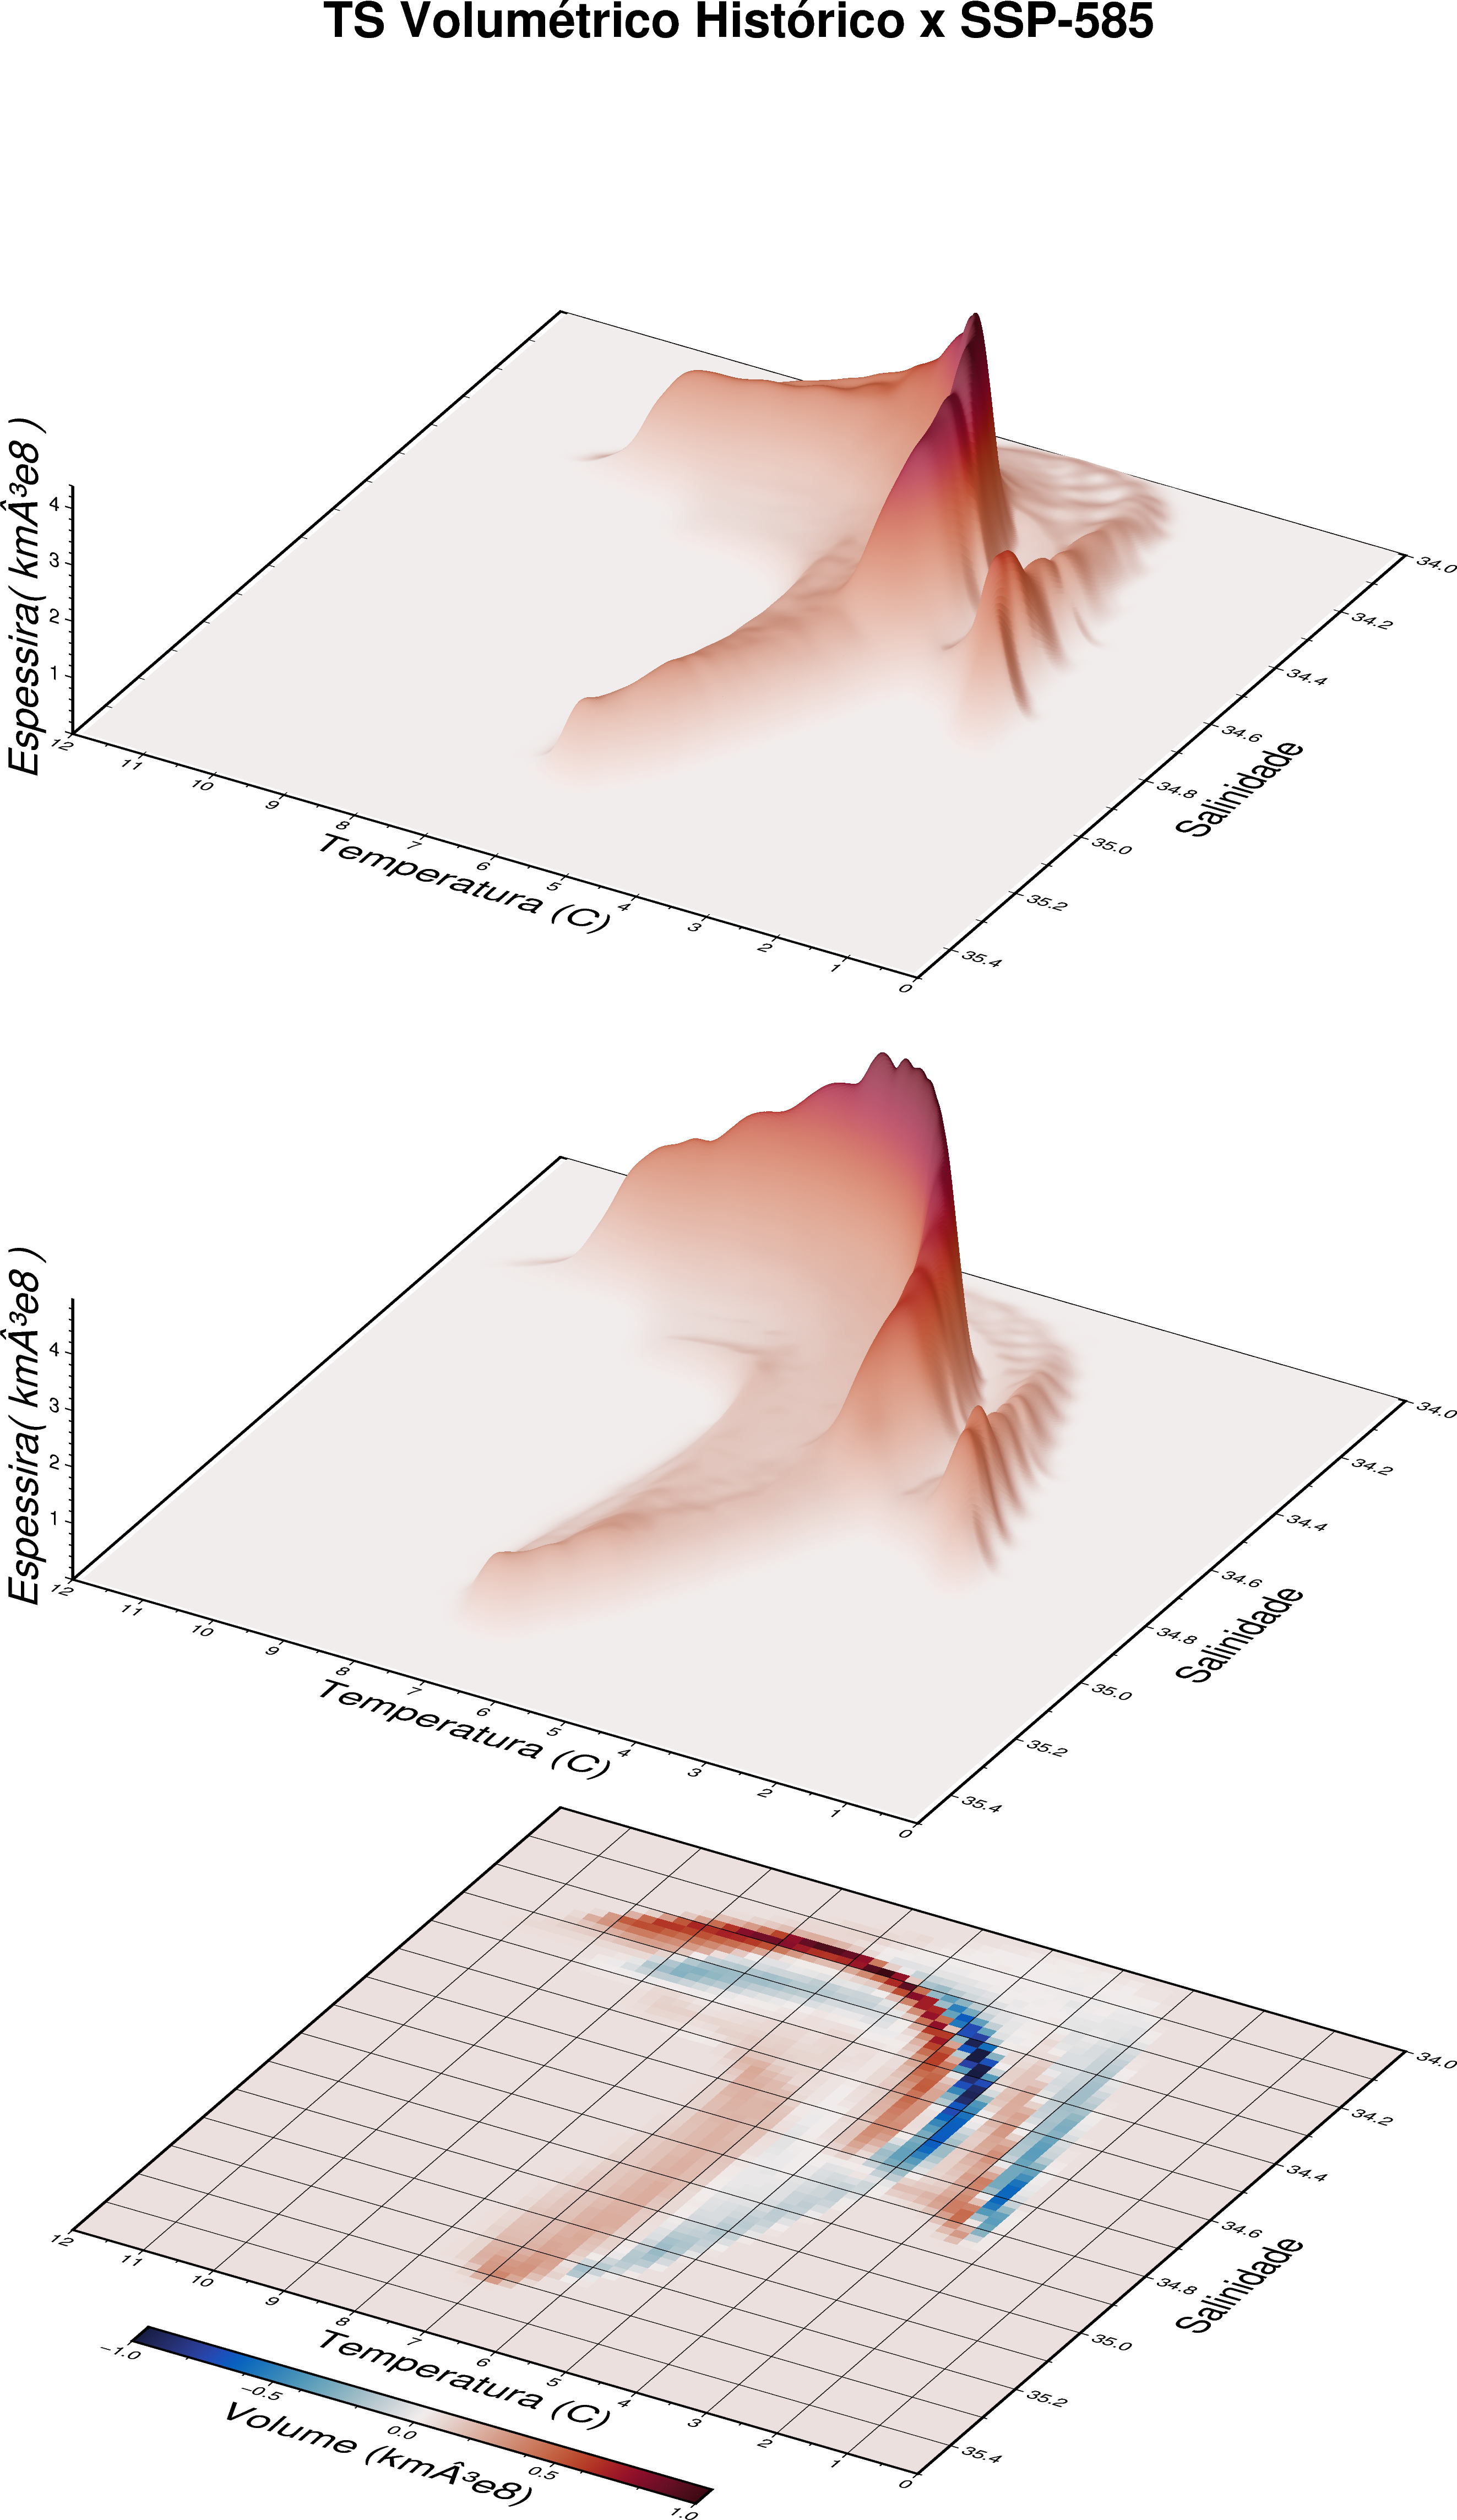

In [44]:

fig3 = pygmt.Figure()
with pygmt.config(FONT_LABEL="20p"):
    
    fig3.grdview(
        grid=grid,
        cmap="cmocean/amp",
        surftype="s",# surface plot
        perspective=[330, 30],  # azimuth bearing, and elevation angle
        zscale=1,
        shading="+a-45+nt0.5",
        interpolation="c",
        frame=[
           "xa1f0.5g+lTemperatura (C)",
            "ya0.2f0.1g+lSalinidade",
            "zaf+lEspessira( km³e8 )",
            "+tTS Volumétrico Histórico x SSP-585"
        ],
        region=[0, 12, 34, 35.5],
        transparency=0)

    fig3.shift_origin(yshift="-13c")

    fig3.grdview(
        grid=grid2,
        cmap="cmocean/amp",
        surftype="s",# surface plot
        perspective=[330, 30],  # azimuth bearing, and elevation angle
        zscale=1,
        shading="+a-45+nt0.5",
        interpolation="c",
        frame=[
           "xa1f0.5+lTemperatura (C)",
            "ya0.2f0.1+lSalinidade",
            "zaf+lEspessira( km³e8 )" 
        ],
        region=[0, 12, 34, 35.5],
        transparency=0)


    fig3.shift_origin(yshift="-10c")


    fig3.grdimage(
        grid=diff,
        perspective=[330, 30],
        region=[0, 12, 34, 35.5],
        frame=[
           "xa1f0.5g+lTemperatura (C)",
            "ya0.2f0.1g+lSalinidade",
        ],
        cmap="cmocean/balance",
        nan_transparent=True)
    
    fig3.colorbar(
    cmap="cmocean/balance",
    perspective=[150, 30],
    frame=[
        "x+lVolume (km³e8)",
        "a0.5f0.2"
    ],
    position="JCB+o0c/2c+w10c/0.5c"
)
    
    """fig3.grdcontour(
        grid=dens.sigma_theta,
        perspective=[330, 30]
        )"""
    
    fig3.savefig("CESM_TS.png")
    fig3.show()